# PART- 3 `( Handling Outliers )`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from scipy.stats.mstats import winsorize

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline
#%matplotlib notebook

plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100pd.set_option('display.max_columns', 500)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_rows = 150
pd.options.display.max_columns = 100

In [2]:
df = pd.read_csv("filled_scout.csv")

## functions to fill the missing values

In [3]:
def fill_most(df, group_col, col_name):
    '''Fills the missing values with the most existing value (mode) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [4]:
def fill_prop(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [5]:
def fill(df, group_col1, group_col2, col_name, method): # method can be "mode" or "median" or "ffill"
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])
                
    elif method == "median":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].median()).fillna(df[cond1][col_name].median()).fillna(df[col_name].median())
                
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [6]:
df.shape

(15919, 25)

In [7]:
df.head(1).T

,0
make_model,Audi A1
body_type,Sedans
price,15770
vat,VAT deductible
km,56013.000
type,Used
fuel,Diesel
gears,7.000
comfort_convenience,"Air conditioning,Armrest,Automatic climate con..."
entertainment_media,"Bluetooth,Hands-free equipment,On-board comput..."


## km

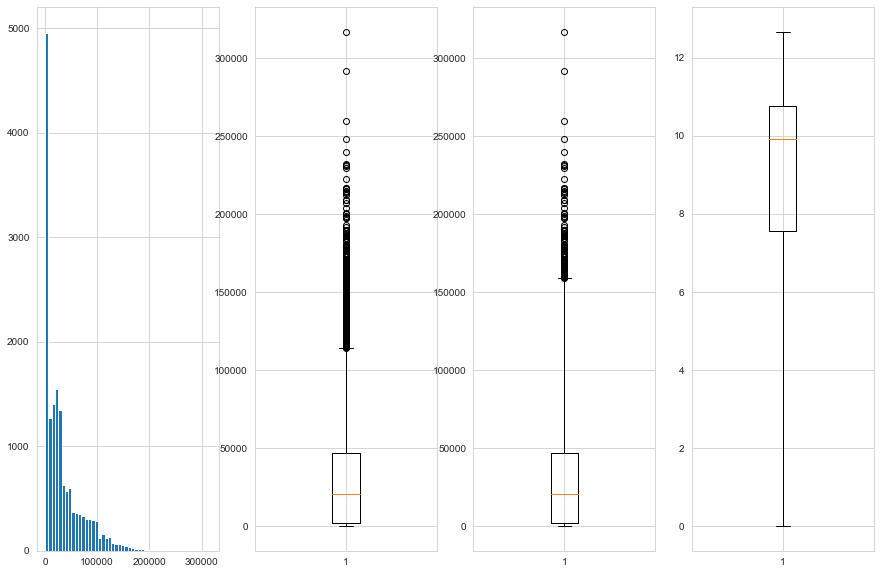

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.hist(df.km, bins = 50)

plt.subplot(142)
plt.boxplot(df.km)

plt.subplot(143)
plt.boxplot(df.km, whis = 2.5)

plt.subplot(144)
plt.boxplot(np.log(df.km), whis = 2.5)
plt.show()

In [9]:
#df["km_logged"] = np.log(df.km)

km is a variable with a wide range of values. We can not consider the outlier values above as a real outliers. So let's keep it as it is.

## cons_comb

In [9]:
df.cons_comb.describe()

count   15919.000
mean        4.832
std         0.868
min         3.000
25%         4.100
50%         4.800
75%         5.400
max         9.100
Name: cons_comb, dtype: float64

In [10]:
df.cons_comb.sort_values().head(10)

6440    3.000
2863    3.000
2862    3.000
13493   3.000
13482   3.000
11004   3.000
11015   3.000
11044   3.000
811     3.000
6240    3.000
Name: cons_comb, dtype: float64

In [11]:
df.cons_comb.sort_values().tail(10)

3601    8.300
3649    8.300
10789   8.600
12553   8.600
12530   8.600
12422   8.600
10817   8.700
12054   8.700
12529   8.700
10771   9.100
Name: cons_comb, dtype: float64

Using our domain knowledge we can conclude that min value of 3 and max value of 9.10 are normal. But anyways, let's analyze outliers with plotting, np.log and winsorize methods.

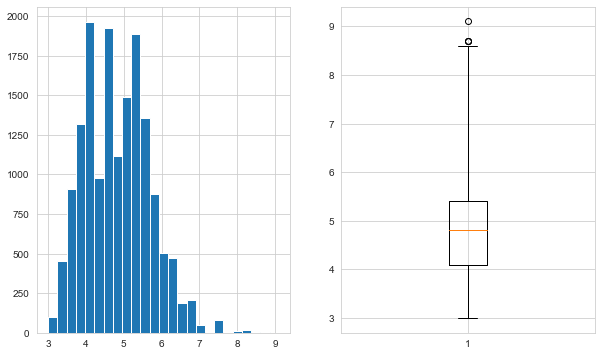

In [13]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.hist(df.cons_comb, bins = 25)

plt.subplot(122)
plt.boxplot(df.cons_comb, whis = 2.5)

plt.show()

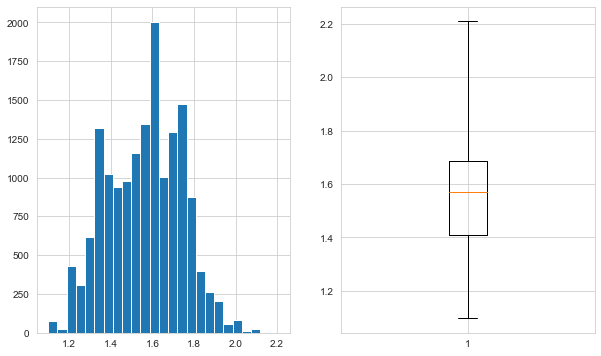

In [14]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.hist(np.log(df.cons_comb), bins = 25)

plt.subplot(122)
plt.boxplot(np.log(df.cons_comb), whis = 2)

plt.show()

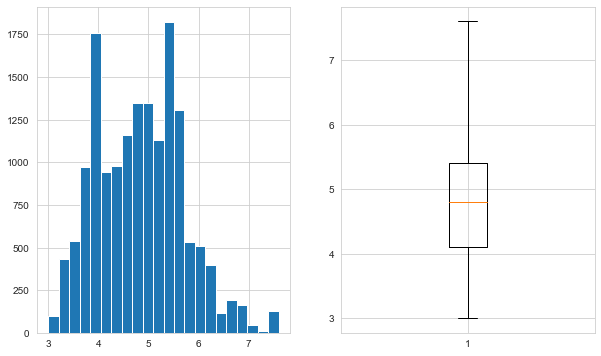

In [15]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.hist(winsorize(df.cons_comb, (0.003)), bins = 22)
# Winsorizing or winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers. 

plt.subplot(122)
plt.boxplot(winsorize(df.cons_comb, (0.003)), whis = 2)

plt.show()

## displacement_cc

In [18]:
df.displacement_cc.describe()

count   15919.000
mean     1425.609
std       329.720
min         1.000
25%      1229.000
50%      1461.000
75%      1598.000
max     16000.000
Name: displacement_cc, dtype: float64

In [20]:
df.sort_values(by = ["displacement_cc"], ascending = False)["displacement_cc"].head(55)

10932   16000.000
7169    15898.000
10771    2967.000
3595     2480.000
3587     2480.000
3649     2480.000
3590     2480.000
3599     2480.000
3598     2480.000
3596     2480.000
3600     2480.000
3601     2480.000
3610     2480.000
3609     2480.000
3608     2480.000
3606     2480.000
3605     2480.000
3648     2480.000
3592     2480.000
3593     2480.000
3602     2480.000
3604     2480.000
3603     2480.000
12176    2000.000
12462    2000.000
12521    2000.000
12170    2000.000
13027    2000.000
11929    2000.000
12179    2000.000
11935    2000.000
12181    2000.000
11800    2000.000
4188     2000.000
12526    2000.000
12959    2000.000
12527    2000.000
11977    2000.000
12469    2000.000
12520    2000.000
12464    2000.000
12265    2000.000
11870    2000.000
10556    2000.000
2903     2000.000
15197    2000.000
12414    2000.000
11988    2000.000
13050    2000.000
12412    2000.000
10464    2000.000
12560    2000.000
12411    2000.000
11032    2000.000
13054    2000.000
Name: disp

In [21]:
df.sort_values(by = ["displacement_cc"], ascending = True)["displacement_cc"].head(55)

12790     1.000
14319     1.000
14315     1.000
12849     1.000
12848     1.000
12835     1.000
12823     1.000
12815     1.000
12800     1.000
12798     1.000
12796     1.000
12786     1.000
12783     1.000
12781     1.000
12769     1.000
12768     1.000
12750     1.000
12670     1.000
12604     1.000
12554     1.000
12501     1.000
12499     1.000
12484     1.000
12473     1.000
12467     1.000
14284     1.000
14320     1.000
14321     1.000
14314     1.000
14322     1.000
14328     1.000
14327     1.000
13904     1.000
14325     1.000
14326     1.000
14324     1.000
10559     2.000
14198     2.000
13912    54.000
10194   122.000
7810    139.000
7812    139.000
7811    139.000
7809    139.000
8128    140.000
15578   160.000
15576   160.000
15574   160.000
15575   160.000
15577   160.000
15579   160.000
13653   890.000
14694   898.000
14342   898.000
14695   898.000
Name: displacement_cc, dtype: float64

In [22]:
outlier_bool_list = df.displacement_cc.isin([1, 2, 54, 122, 139, 140, 160, 16000, 15898])

In [23]:
outlier_bool_list

0        False
1        False
2        False
3        False
4        False
         ...  
15914    False
15915    False
15916    False
15917    False
15918    False
Name: displacement_cc, Length: 15919, dtype: bool

In [24]:
df.loc[outlier_bool_list, "displacement_cc"] = np.nan

In [25]:
fill(df, "make_model", "body_type", "displacement_cc", "mode")

Number of NaN :  0
------------------
1598.000    5077
999.000     2467
1398.000    1388
1399.000     772
1461.000     682
1229.000     678
1956.000     670
1490.000     559
1422.000     467
1197.000     372
898.000      351
1395.000     320
1968.000     301
1149.000     288
1618.000     212
1798.000     210
1498.000     196
1600.000     130
1248.000     110
1997.000     103
1364.000     102
1400.000      90
998.000       72
1500.000      50
2000.000      46
1000.000      40
1998.000      25
2480.000      20
1984.000      18
1200.000      18
899.000       11
1397.000      11
1499.000       5
929.000        5
1596.000       4
900.000        4
997.000        4
1396.000       3
1199.000       3
1599.000       3
1589.000       2
995.000        2
1300.000       2
1495.000       2
1390.000       1
1696.000       1
1568.000       1
1368.000       1
890.000        1
1239.000       1
1496.000       1
973.000        1
996.000        1
1198.000       1
1333.000       1
1584.000       1
1686.000  

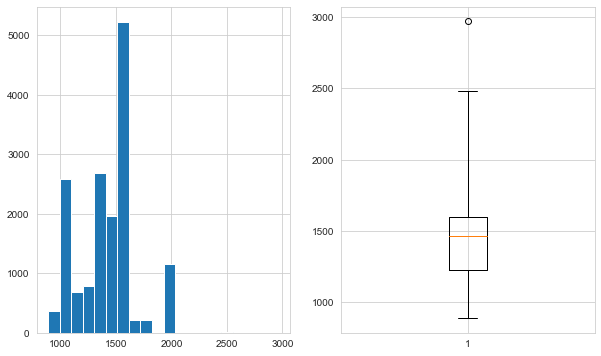

In [26]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(df.displacement_cc, bins = 20)

plt.subplot(122)
plt.boxplot(df.displacement_cc, whis = 2.5)

plt.show()

- There is no problem in terms of outliers

## Nr_of_Doors

In [27]:
df.nr_of_doors.value_counts(dropna = False)

5.000    11787
4.000     3079
3.000      832
2.000      219
7.000        1
1.000        1
Name: nr_of_doors, dtype: int64

In [28]:
df.nr_of_doors.replace([1, 7], np.nan, inplace=True)

In [29]:
df.nr_of_doors.value_counts(dropna = False)

5.000    11787
4.000     3079
3.000      832
2.000      219
NaN          2
Name: nr_of_doors, dtype: int64

In [30]:
fill(df, "make_model", "body_type", "nr_of_doors", "mode")

Number of NaN :  0
------------------
5.000    11789
4.000     3079
3.000      832
2.000      219
Name: nr_of_doors, dtype: int64


<AxesSubplot:>

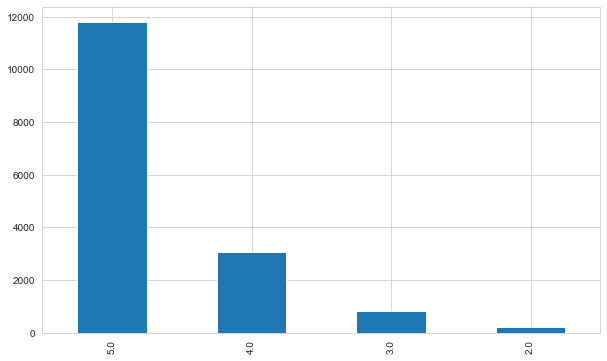

In [31]:
df.nr_of_doors.value_counts(dropna = False).plot.bar()

<AxesSubplot:xlabel='make_model,nr_of_doors'>

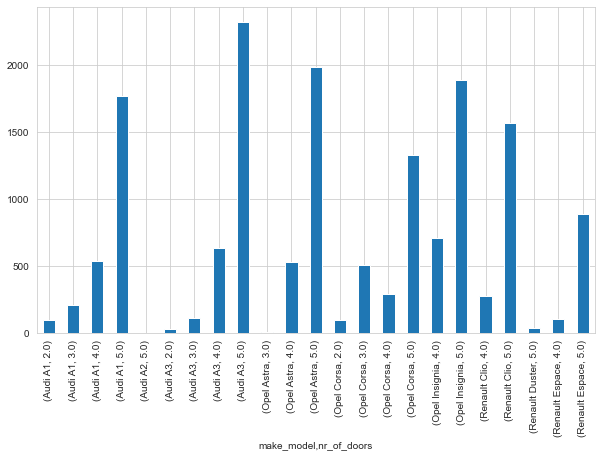

In [32]:
df.groupby(["make_model", "nr_of_doors"]).nr_of_doors.count().plot.bar()

In [33]:
df.drop("nr_of_doors", axis=1, inplace=True)

## Nr_of_Seats

In [34]:
df.nr_of_seats.value_counts(dropna = False)

5.000    14308
4.000     1127
7.000      362
2.000      119
6.000        2
3.000        1
Name: nr_of_seats, dtype: int64

In [35]:
df.nr_of_seats.replace([3, 6], np.nan, inplace=True)

In [36]:
df.nr_of_seats.value_counts(dropna = False)

5.000    14308
4.000     1127
7.000      362
2.000      119
NaN          3
Name: nr_of_seats, dtype: int64

In [37]:
fill(df, "make_model", "body_type", "nr_of_seats", "mode")

Number of NaN :  0
------------------
5.000    14311
4.000     1127
7.000      362
2.000      119
Name: nr_of_seats, dtype: int64


<AxesSubplot:>

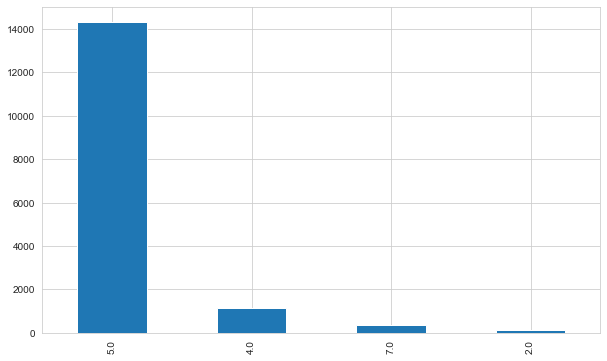

In [38]:
df.nr_of_seats.value_counts(dropna = False).plot.bar()

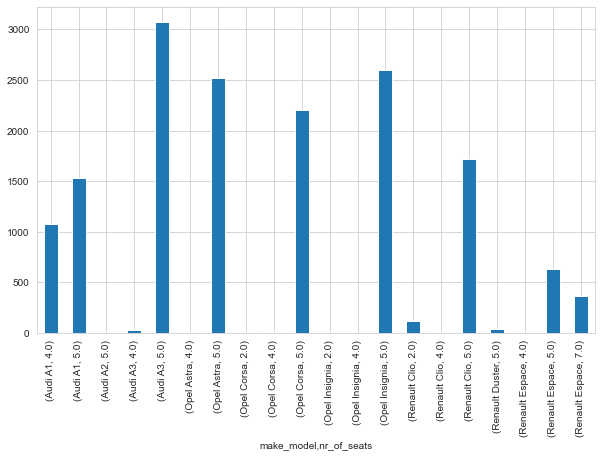

In [41]:
df.groupby(["make_model", "nr_of_seats"]).nr_of_seats.count().plot.bar();

In [42]:
df.drop("nr_of_seats", axis=1, inplace=True)

## Weight_kg

In [43]:
df.weight_kg.describe()

count   15919.000
mean     1337.432
std       200.466
min         1.000
25%      1165.000
50%      1295.000
75%      1472.000
max      2471.000
Name: weight_kg, dtype: float64

In [44]:
df["weight_kg"].sort_values().head(10)

8355      1.000
12779     1.000
1143    102.000
8857    840.000
14313   900.000
13513   977.000
13555   977.000
14654   980.000
14105   980.000
13999   980.000
Name: weight_kg, dtype: float64

In [45]:
df["weight_kg"].replace([1, 102], np.nan, inplace = True)

In [46]:
df["weight_kg"].isnull().sum()

3

In [47]:
fill(df, "make_model", "body_type", "weight_kg", "mode")

Number of NaN :  0
------------------
1163.000    1583
1360.000    1419
1487.000     967
1135.000     837
1425.000     744
            ... 
1797.000       1
1950.000       1
900.000        1
1272.000       1
1159.000       1
Name: weight_kg, Length: 432, dtype: int64


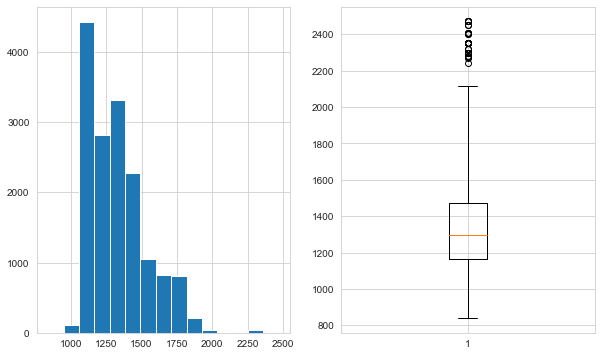

In [49]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(df.weight_kg, bins=15)

plt.subplot(122)
plt.boxplot(df.weight_kg, whis=2.5)

plt.show()

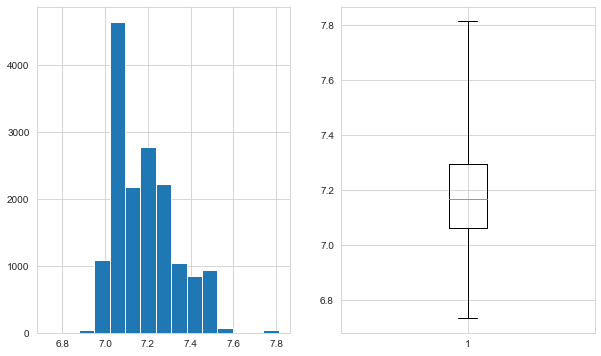

In [50]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(np.log(df.weight_kg), bins=15)

plt.subplot(122)
plt.boxplot(np.log(df.weight_kg), whis=2.5)

plt.show()

## hp_kW

In [51]:
df.hp_kw.describe()

count   15919.000
mean       88.374
std        26.844
min         1.000
25%        66.000
50%        85.000
75%       101.000
max       294.000
Name: hp_kw, dtype: float64

In [52]:
df.hp_kw.sort_values().head(50)

6034     1.000
6946     1.000
7014     1.000
9285     1.000
9287     1.000
6005     1.000
9288     1.000
7018     1.000
9289     1.000
9290     1.000
9292     1.000
9299     1.000
10610    1.000
10580    1.000
10579    1.000
10468    1.000
15155    1.000
15156    1.000
7019     1.000
7016     1.000
13885    4.000
3913     9.000
8857    40.000
13759   40.000
8408    44.000
10282   51.000
10283   51.000
10284   51.000
10285   51.000
10286   51.000
10287   51.000
9145    51.000
10288   51.000
10346   51.000
10281   51.000
10330   51.000
9026    51.000
9025    51.000
10342   51.000
10289   51.000
9159    51.000
9384    51.000
9158    51.000
10290   51.000
10291   51.000
10345   51.000
10280   51.000
10279   51.000
10278   51.000
10264   51.000
Name: hp_kw, dtype: float64

In [53]:
df.hp_kw.unique()

array([ 66., 141.,  85.,  70.,  92., 112.,  60.,  71.,  67., 110.,  93.,
       147.,  86., 140.,  87.,  81.,  82., 135., 132., 100.,  96., 162.,
       150., 294., 228., 270., 137.,   9., 133.,  77., 101.,  78., 103.,
         1.,  74., 118.,  84.,  88.,  80.,  76., 149.,  51.,  44.,  55.,
        52.,  63.,  40.,  65.,  75., 125., 120., 184., 239., 121., 143.,
       191.,  89., 195., 127., 122., 154., 155., 104., 123., 146.,  90.,
        56.,  53.,  54., 164.,   4., 163.,  57., 119., 165., 117., 115.,
        98., 168., 167.])

In [54]:
df.hp_kw.loc[df.hp_kw < 40] = np.nan

In [55]:
df.hp_kw.isnull().sum()

22

In [56]:
fill(df, "make_model", "body_type", "hp_kw", "mode")

Number of NaN :  0
------------------
85.000     2544
66.000     2124
81.000     1403
100.000    1317
110.000    1117
70.000      890
125.000     715
51.000      703
55.000      589
118.000     552
92.000      466
121.000     392
147.000     380
77.000      353
56.000      295
54.000      276
103.000     253
87.000      232
165.000     194
88.000      177
60.000      160
162.000      98
74.000       81
96.000       72
71.000       59
101.000      47
67.000       40
154.000      39
122.000      35
119.000      30
164.000      27
135.000      24
82.000       22
52.000       22
78.000       20
146.000      18
294.000      18
141.000      16
57.000       10
120.000       8
104.000       8
191.000       7
112.000       7
155.000       6
117.000       6
184.000       5
90.000        4
65.000        4
76.000        4
98.000        3
80.000        3
93.000        3
149.000       3
168.000       3
40.000        2
86.000        2
53.000        2
228.000       2
167.000       2
143.000       2
15

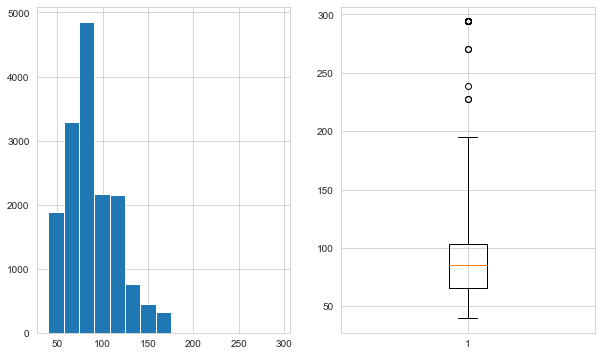

In [57]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(df.hp_kw, bins=15)

plt.subplot(122)
plt.boxplot(df.hp_kw, whis=2.5)

plt.show()

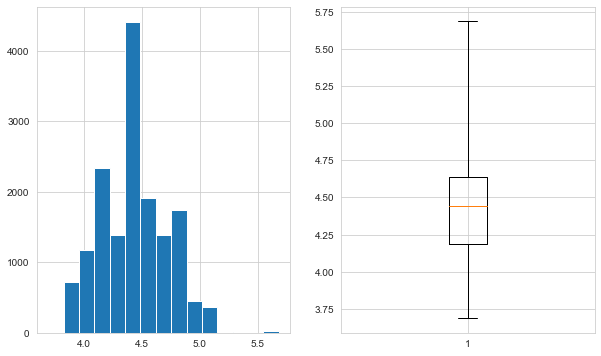

In [58]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(np.log(df.hp_kw), bins=15)

plt.subplot(122)
plt.boxplot(np.log(df.hp_kw), whis=2.5)

plt.show()

## price

In [59]:
df.price.describe()

count   15919.000
mean    18019.897
std      7386.169
min        13.000
25%     12850.000
50%     16900.000
75%     21900.000
max     74600.000
Name: price, dtype: float64

In [60]:
df.price.sort_values().head(5)

8594      13
8828     120
6066     255
8829     331
8827    4950
Name: price, dtype: int64

In [61]:
df.drop(index = [8594, 8828, 6066,8829], axis = 0, inplace = True)

In [62]:
df.shape

(15915, 23)

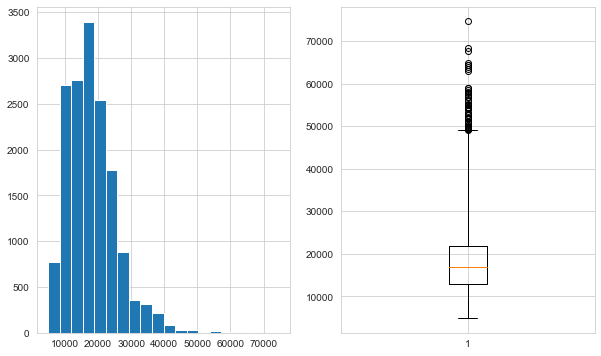

In [63]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(df.price, bins=20)

plt.subplot(122)
plt.boxplot(df.price, whis=3)

plt.show()

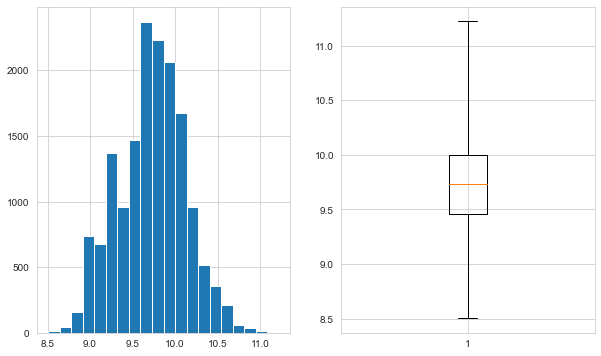

In [64]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(np.log(df.price), bins=20)

plt.subplot(122)
plt.boxplot(np.log(df.price), whis=2.3)

plt.show()

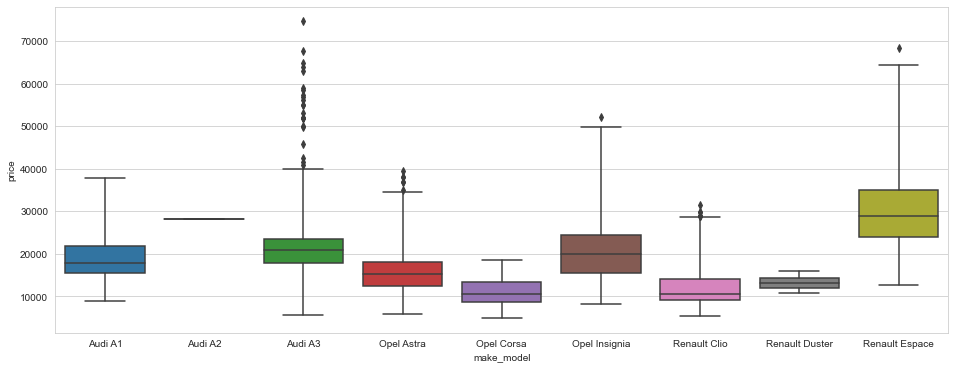

In [65]:
plt.figure(figsize=(16,6))
sns.boxplot(x="make_model", y="price", data=df, whis=3)
plt.show()

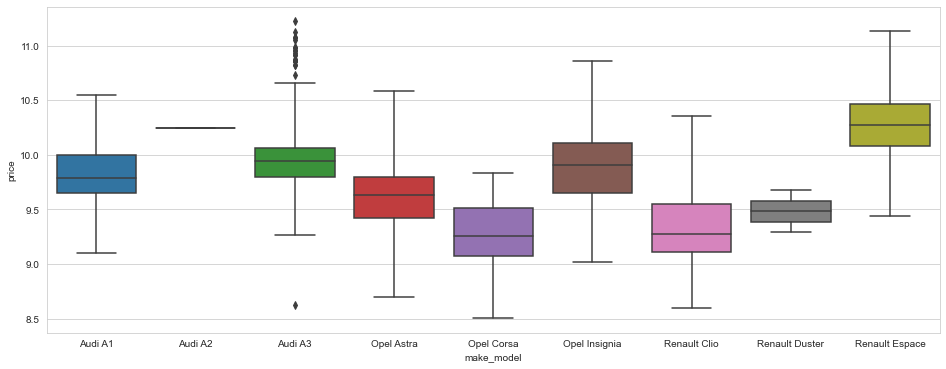

In [66]:
plt.figure(figsize=(16,6))
sns.boxplot(x="make_model", y=np.log(df.price), data=df, whis=2.3)
plt.show()

## Final_Step

In [67]:
df.head(3).T

,0,1,2
make_model,Audi A1,Audi A1,Audi A1
body_type,Sedans,Sedans,Sedans
price,15770,14500,14640
vat,VAT deductible,Price negotiable,VAT deductible
km,56013.000,80000.000,83450.000
type,Used,Used,Used
fuel,Diesel,Benzine,Diesel
gears,7.000,7.000,7.000
comfort_convenience,"Air conditioning,Armrest,Automatic climate con...","Air conditioning,Automatic climate control,Hil...","Air conditioning,Cruise control,Electrical sid..."
entertainment_media,"Bluetooth,Hands-free equipment,On-board comput...","Bluetooth,Hands-free equipment,On-board comput...","MP3,On-board computer"


In [68]:
numeric_col = "price,km,gears,previous_owners,cons_comb,displacement_cc,age,hp_kw,weight_kg".split(",")

In [69]:
df_num = df[numeric_col]

In [70]:
df_num

,price,km,gears,previous_owners,cons_comb,displacement_cc,age,hp_kw,weight_kg
0,15770,56013.000,7.000,2.000,3.800,1422.000,3.000,66.000,1220.000
1,14500,80000.000,7.000,1.000,5.600,1798.000,2.000,141.000,1255.000
2,14640,83450.000,7.000,1.000,3.800,1598.000,3.000,85.000,1135.000
3,14500,73000.000,6.000,1.000,3.800,1422.000,3.000,66.000,1195.000
4,16790,16200.000,7.000,1.000,4.100,1422.000,3.000,66.000,1135.000
...,...,...,...,...,...,...,...,...,...
15914,39950,1647.363,6.000,1.000,5.300,1997.000,0.000,147.000,1758.000
15915,39885,9900.000,7.000,1.000,7.400,1798.000,0.000,165.000,1708.000
15916,39875,15.000,6.000,1.000,5.300,1997.000,0.000,146.000,1734.000
15917,39700,10.000,6.000,1.000,5.300,1997.000,0.000,147.000,1758.000


<AxesSubplot:>

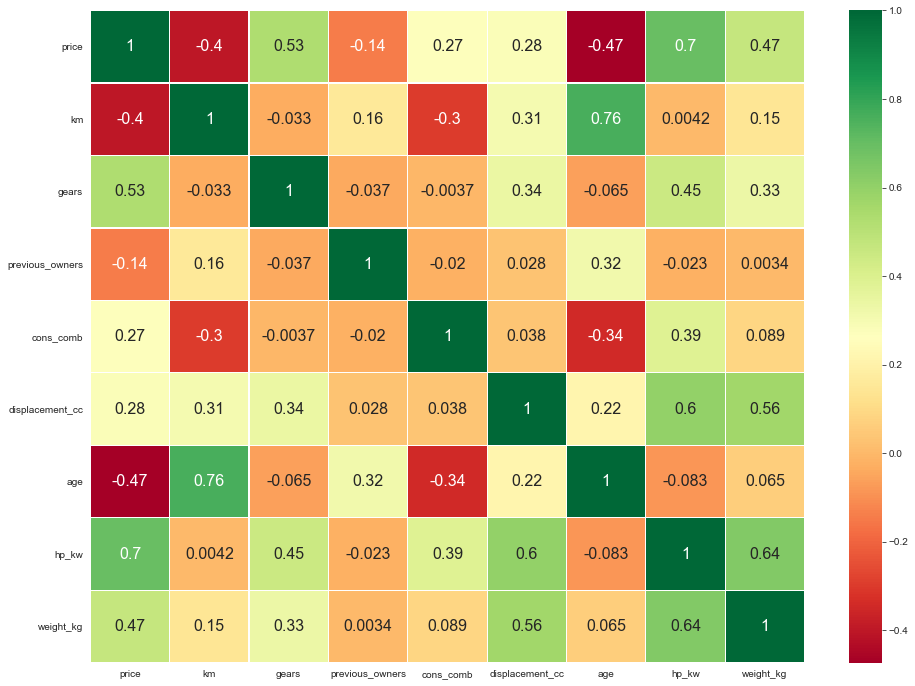

In [71]:
plt.figure(figsize = (16,12))
sns.heatmap(df_num.corr(), annot = True, cmap="RdYlGn", linewidths=0.2, annot_kws = {"size": 16})

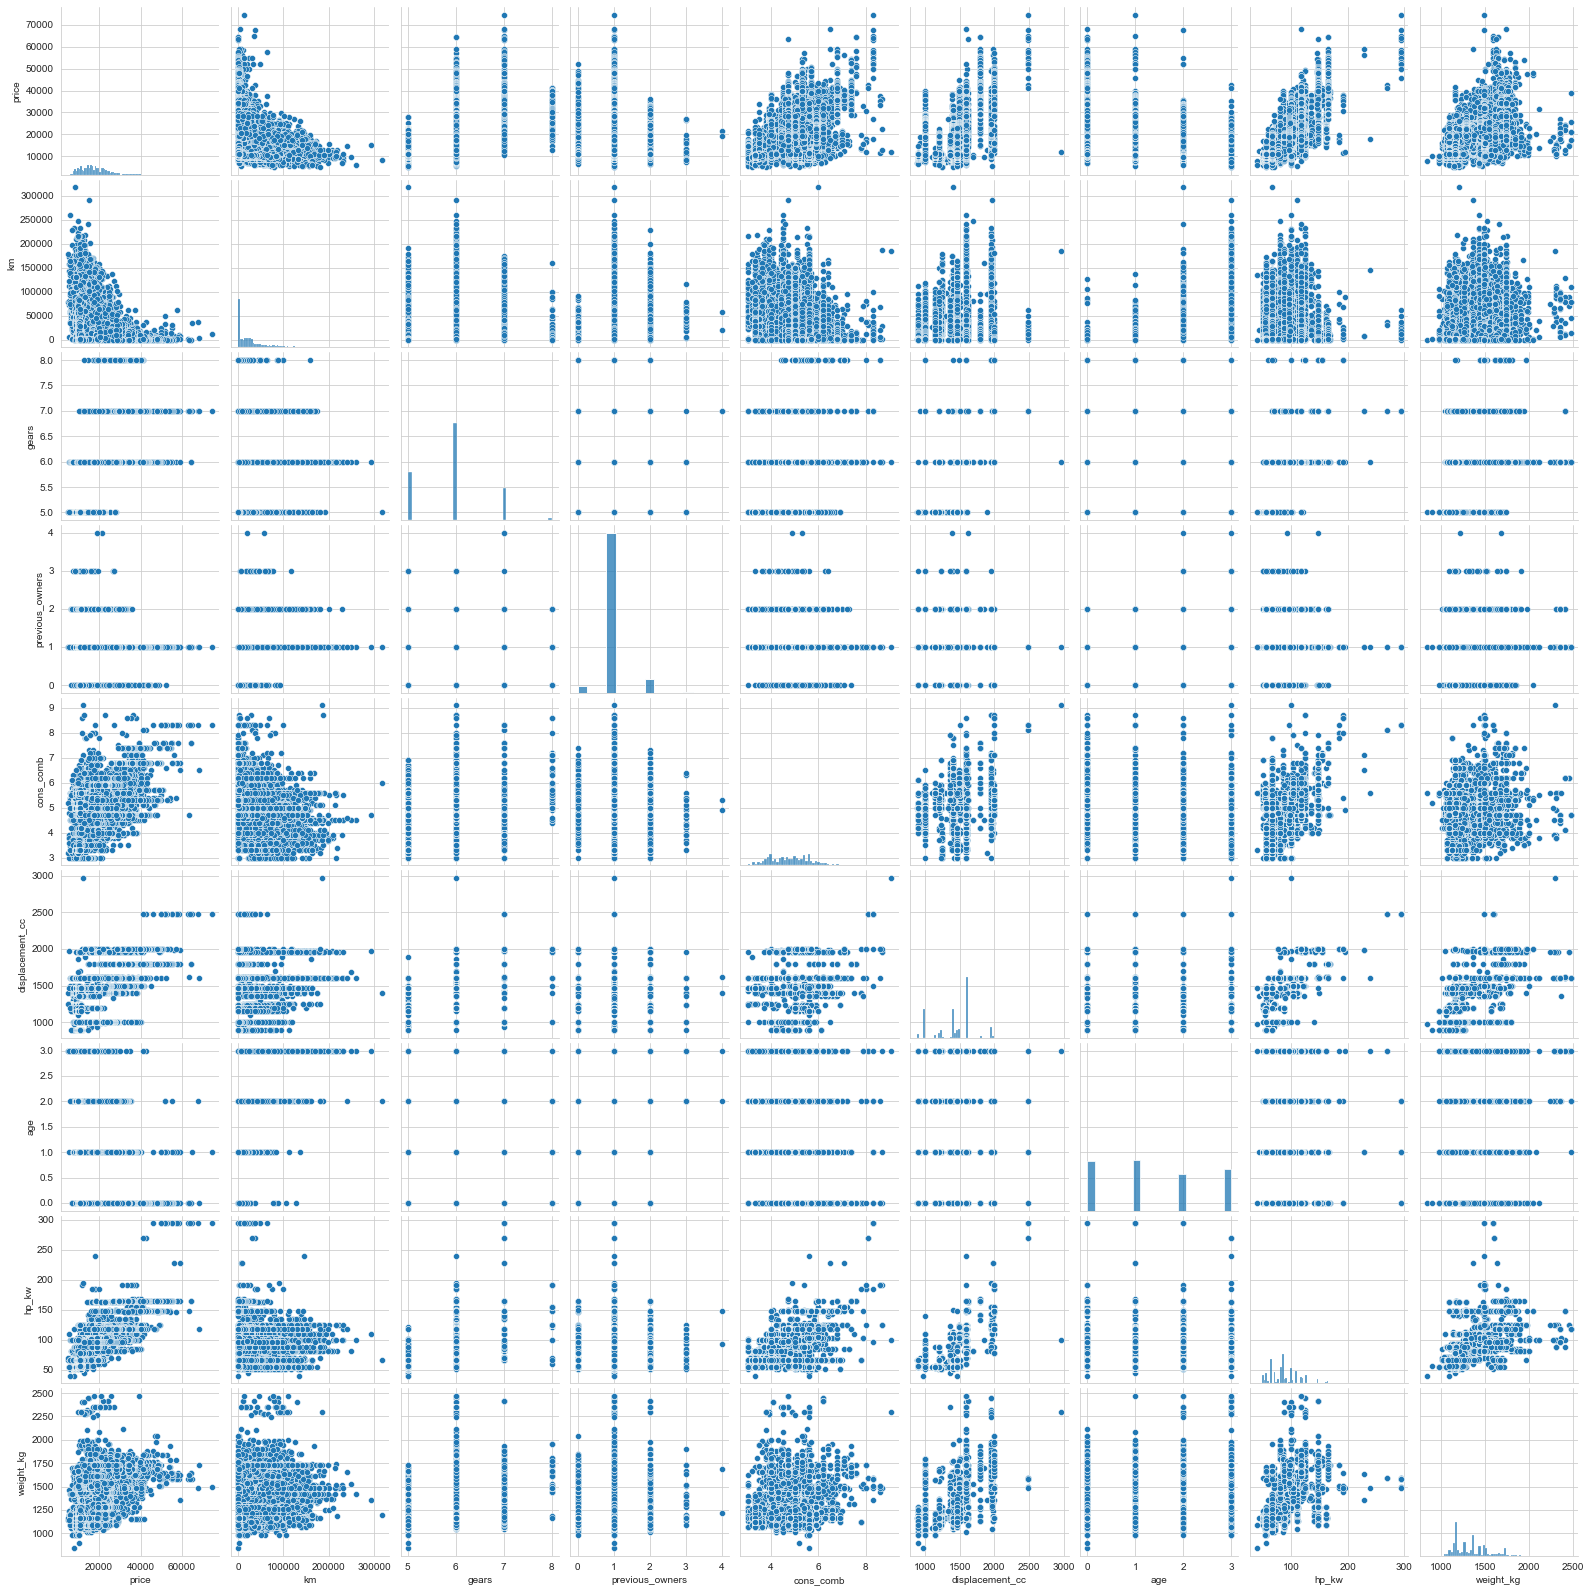

In [72]:
sns.pairplot(df_num, size = 2.5)
plt.show()

## Dummy Operation

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15915 entries, 0 to 15918
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make_model           15915 non-null  object 
 1   body_type            15915 non-null  object 
 2   price                15915 non-null  int64  
 3   vat                  15915 non-null  object 
 4   km                   15915 non-null  float64
 5   type                 15915 non-null  object 
 6   fuel                 15915 non-null  object 
 7   gears                15915 non-null  float64
 8   comfort_convenience  15915 non-null  object 
 9   entertainment_media  15915 non-null  object 
 10  extras               15915 non-null  object 
 11  safety_security      15915 non-null  object 
 12  age                  15915 non-null  float64
 13  previous_owners      15915 non-null  float64
 14  hp_kw                15915 non-null  float64
 15  inspection_new       15915 non-null 

In [74]:
df.shape

(15915, 23)

In [75]:
df.to_csv("final_scout_not_dummy.csv", index=False)

In [76]:
df[["comfort_convenience", "entertainment_media", "extras", "safety_security"]]

,comfort_convenience,entertainment_media,extras,safety_security
0,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,Hands-free equipment,On-board comput...","Alloy wheels,Catalytic Converter,Voice Control","ABS,Central door lock,Daytime running lights,D..."
1,"Air conditioning,Automatic climate control,Hil...","Bluetooth,Hands-free equipment,On-board comput...","Alloy wheels,Sport seats,Sport suspension,Voic...","ABS,Central door lock,Central door lock with r..."
2,"Air conditioning,Cruise control,Electrical sid...","MP3,On-board computer","Alloy wheels,Voice Control","ABS,Central door lock,Daytime running lights,D..."
3,"Air suspension,Armrest,Auxiliary heating,Elect...","Bluetooth,CD player,Hands-free equipment,MP3,O...","Alloy wheels,Sport seats,Voice Control","ABS,Alarm system,Central door lock with remote..."
4,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,CD player,Hands-free equipment,MP3,O...","Alloy wheels,Sport package,Sport suspension,Vo...","ABS,Central door lock,Driver-side airbag,Elect..."
...,...,...,...,...
15914,"Air conditioning,Automatic climate control,Cru...","Bluetooth,Digital radio,Hands-free equipment,O...","Alloy wheels,Touch screen","ABS,Central door lock,Central door lock with r..."
15915,"Air conditioning,Automatic climate control,Cru...","Bluetooth,Digital radio,Hands-free equipment,R...","Alloy wheels,Touch screen,Voice Control","ABS,Adaptive Cruise Control,Blind spot monitor..."
15916,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,Hands-free equipment,On-board comput...",Alloy wheels,"ABS,Adaptive Cruise Control,Blind spot monitor..."
15917,"Air conditioning,Automatic climate control,Cru...","Bluetooth,Digital radio,Radio,USB","Alloy wheels,Touch screen","ABS,Blind spot monitor,Driver-side airbag,Elec..."


In [77]:
# STR + GET_DUMMIES

df = df.join(df["comfort_convenience"].str.get_dummies(sep = ",").add_prefix("cc_"))
df = df.join(df["entertainment_media"].str.get_dummies(sep = ",").add_prefix("em_"))
df = df.join(df["extras"].str.get_dummies(sep = ",").add_prefix("ex_"))
df = df.join(df["safety_security"].str.get_dummies(sep = ",").add_prefix("ss_"))

In [78]:
df.drop(["comfort_convenience", "entertainment_media", "extras", "safety_security"], axis=1, inplace=True)

In [79]:
df.shape

(15915, 113)

In [80]:
df_final = pd.get_dummies(df)

In [81]:
df_final.shape

(15915, 143)

In [84]:
len(df_final.columns)

143

In [85]:
df_final.head().T

,0,1,2,3,4
price,15770.000,14500.000,14640.000,14500.000,16790.000
km,56013.000,80000.000,83450.000,73000.000,16200.000
gears,7.000,7.000,7.000,6.000,7.000
age,3.000,2.000,3.000,3.000,3.000
previous_owners,2.000,1.000,1.000,1.000,1.000
hp_kw,66.000,141.000,85.000,66.000,66.000
inspection_new,1.000,0.000,0.000,0.000,1.000
displacement_cc,1422.000,1798.000,1598.000,1422.000,1422.000
weight_kg,1220.000,1255.000,1135.000,1195.000,1135.000
cons_comb,3.800,5.600,3.800,3.800,4.100


In [86]:
df_final.to_csv("final_scout_dummy.csv", index=False)